In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    filtered_cv_results['n_iter'] = cv_results['mean_train_n_iter'].round().astype(int) + 1
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [5]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [6]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


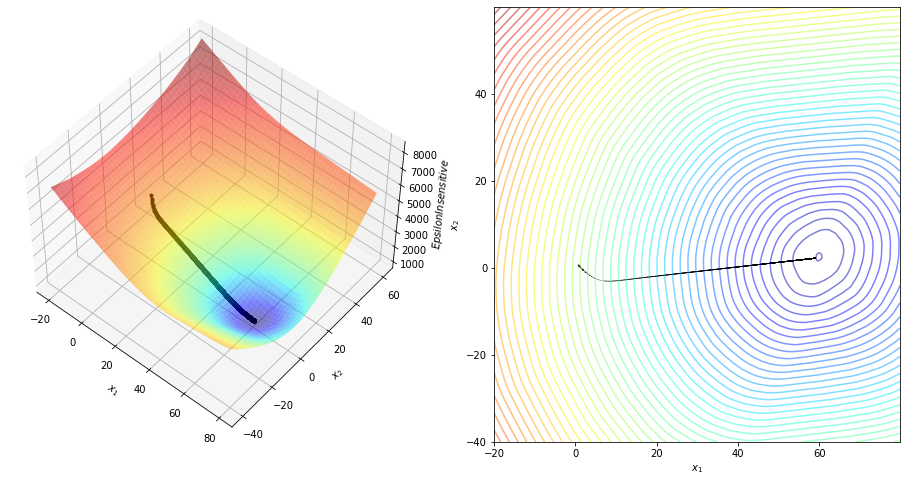

In [7]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=1, 
                              max_iter=4000, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [8]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_primal_svr_eps_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  \
solver  C   epsilon                                                     
adagrad 1   0.1      0.692084  0.919185  0.915674     876          66   
            0.2      0.701444  0.920036  0.916541     895          66   
            0.3      0.684244  0.920119  0.916694     890          65   
        10  0.1      2.629582  0.977826  0.972929    3560          65   
            0.2      2.797290  0.977797  0.972832    3526          65   
            0.3      2.594063  0.977778  0.972872    3446          65   
        100 0.1      2.818639  0.978125  0.974200    4000          66   
            0.2      2.674827  0.978118  0.974194    4000          66   
            0.3      2.300388  0.978119  0.974199    4000          66   

                     val_n_sv  
solver  C   epsilon            
adagrad 1   0.1            33  
            0.2            33  
            0.3            33  
        10  0.1            32  
            0.2            32  
            0.3            32  
        100 0.1            33  
            0.2            32  
            0.3            32

In [9]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [10]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  \
solver    C   epsilon                                                     
liblinear 1   0.1      0.000605  0.918867  0.916885      13          65   
              0.2      0.000638  0.918866  0.916725      13          65   
              0.3      0.000583  0.919243  0.916993      13          65   
          10  0.1      0.000654  0.977853  0.972064     156          65   
              0.2      0.000704  0.977852  0.972041     164          65   
              0.3      0.000654  0.977870  0.972142     107          64   
          100 0.1      0.000954  0.977723  0.974270     681          65   
              0.2      0.001165  0.977642  0.973861     710          65   
              0.3      0.001070  0.977654  0.974052     809          65   

                       val_n_sv  
solver    C   epsilon            
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

In [11]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='h!')
primal_svr_eps_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  \
solver    C   epsilon                                                     
adagrad   1   0.1      0.692084  0.919185  0.915674     876          66   
              0.2      0.701444  0.920036  0.916541     895          66   
              0.3      0.684244  0.920119  0.916694     890          65   
          10  0.1      2.629582  0.977826  0.972929    3560          65   
              0.2      2.797290  0.977797  0.972832    3526          65   
              0.3      2.594063  0.977778  0.972872    3446          65   
          100 0.1      2.818639  0.978125  0.974200    4000          66   
              0.2      2.674827  0.978118  0.974194    4000          66   
              0.3      2.300388  0.978119  0.974199    4000          66   
liblinear 1   0.1      0.000605  0.918867  0.916885      13          65   
              0.2      0.000638  0.918866  0.916725      13          65   
              0.3      0.000583  0.919243  0.916993      13          65   
          10  0.1      0.000654  0.977853  0.972064     156          65   
              0.2      0.000704  0.977852  0.972041     164          65   
              0.3      0.000654  0.977870  0.972142     107          64   
          100 0.1      0.000954  0.977723  0.974270     681          65   
              0.2      0.001165  0.977642  0.973861     710          65   
              0.3      0.001070  0.977654  0.974052     809          65   

                       val_n_sv  
solver    C   epsilon            
adagrad   1   0.1            33  
              0.2            33  
              0.3            33  
          10  0.1            32  
              0.2            32  
              0.3            32  
          100 0.1            33  
              0.2            32  
              0.3            32  
liblinear 1   0.1            33  
              0.2            32  
              0.3            32  
          10  0.1            33  
              0.2            33  
              0.3            33  
          100 0.1            33  
              0.2            33  
              0.3            33

### Dual formulations

In [12]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [13]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [14]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (0 if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter), 
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


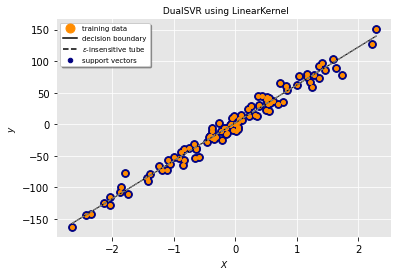

In [54]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [55]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results['n_iter'].replace(0, '-', inplace=True)
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.046771  0.917772  0.914479       1          67        67
           0.2      0.043559  0.918341  0.915058       1          67        67
           0.3      0.043129  0.918942  0.915614       1          66        66
       10  0.1      0.031975  0.977920  0.972466       1          67        67
           0.2      0.020005  0.977926  0.972474       1          67        67
           0.3      0.015315  0.977954  0.972562       1          66        66
       100 0.1      0.013129  0.977788  0.974150       1          67        67
           0.2      0.013004  0.977742  0.974033       1          67        67
           0.3      0.012722  0.977737  0.973956       1          67        67
smo    1   0.1      0.053333  0.917773  0.914442      15          66        66
           0.2      0.061615  0.918341  0.915019      13          66        66
           0.3      0.085741  0.918942  0.915576      60          66        66
       10  0.1      0.114405  0.977920  0.972445      56          66        66
           0.2      0.194250  0.977926  0.972457     219          65        65
           0.3      0.072651  0.977953  0.972544      38          65        65
       100 0.1      0.610673  0.977788  0.974139    1508          66        66
           0.2      0.297791  0.977742  0.974022     394          66        66
           0.3      0.487787  0.977737  0.973939     900          66        66

In [51]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [52]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  val_n_sv
solver C   epsilon                                                            
libsvm 1   0.1      0.005714  0.917627  0.915448      64          66        66
           0.2      0.008318  0.918194  0.915985     103          66        66
           0.3      0.005886  0.918786  0.916554      55          66        66
       10  0.1      0.005883  0.977852  0.972051     283          66        66
           0.2      0.005896  0.977851  0.972025     194          65        65
           0.3      0.006089  0.977870  0.972135     594          65        65
       100 0.1      0.010685  0.977723  0.974270    2622          66        66
           0.2      0.014737  0.977673  0.974122    2710          66        66
           0.3      0.010669  0.977655  0.974045    4142          66        66

In [56]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='h!')
linear_dual_svr_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.046771  0.917772  0.914479       1          67        67
           0.2      0.043559  0.918341  0.915058       1          67        67
           0.3      0.043129  0.918942  0.915614       1          66        66
       10  0.1      0.031975  0.977920  0.972466       1          67        67
           0.2      0.020005  0.977926  0.972474       1          67        67
           0.3      0.015315  0.977954  0.972562       1          66        66
       100 0.1      0.013129  0.977788  0.974150       1          67        67
           0.2      0.013004  0.977742  0.974033       1          67        67
           0.3      0.012722  0.977737  0.973956       1          67        67
smo    1   0.1      0.053333  0.917773  0.914442      15          66        66
           0.2      0.061615  0.918341  0.915019      13          66        66
           0.3      0.085741  0.918942  0.915576      60          66        66
       10  0.1      0.114405  0.977920  0.972445      56          66        66
           0.2      0.194250  0.977926  0.972457     219          65        65
           0.3      0.072651  0.977953  0.972544      38          65        65
       100 0.1      0.610673  0.977788  0.974139    1508          66        66
           0.2      0.297791  0.977742  0.974022     394          66        66
           0.3      0.487787  0.977737  0.973939     900          66        66
libsvm 1   0.1      0.005714  0.917627  0.915448      64          66        66
           0.2      0.008318  0.918194  0.915985     103          66        66
           0.3      0.005886  0.918786  0.916554      55          66        66
       10  0.1      0.005883  0.977852  0.972051     283          66        66
           0.2      0.005896  0.977851  0.972025     194          65        65
           0.3      0.006089  0.977870  0.972135     594          65        65
       100 0.1      0.010685  0.977723  0.974270    2622          66        66
           0.2      0.014737  0.977673  0.974122    2710          66        66
           0.3      0.010669  0.977655  0.974045    4142          66        66

##### Nonlinear

In [ ]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results['n_iter'].replace(0, '-', inplace=True)
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

Fitting 3 folds for each of 18 candidates, totalling 54 fits


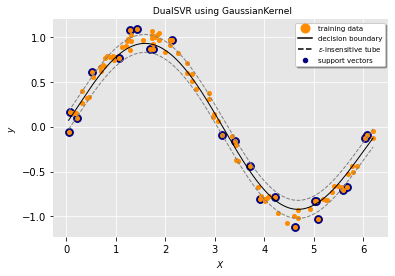

In [17]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [21]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results['n_iter'].replace(0, '-', inplace=True)
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  \
solver kernel C   epsilon                                                     
cvxopt rbf    1   0.1      0.017533  0.981693  0.180471       1          16   
                  0.2      0.012594  0.956734 -0.439549       1           6   
                  0.3      0.015533  0.880952 -0.602632       1           4   
              10  0.1      0.012865  0.985660  0.567755       1          18   
                  0.2      0.014866  0.955086 -0.442573       1           5   
                  0.3      0.014637  0.885698 -0.574373       1           4   
              100 0.1      0.012910  0.985397  0.528558       1          20   
                  0.2      0.013090  0.955086 -0.442574       1           5   
                  0.3      0.012432  0.881117 -0.596409       1           4   
smo    rbf    1   0.1      0.071944  0.982028  0.136885      46          16   
                  0.2      0.016090  0.955558 -0.550490      13           6   
                  0.3      0.008809  0.890942 -0.817168       9           4   
              10  0.1      0.366856  0.982839  0.507480     304          17   
                  0.2      0.025733  0.953008 -0.554380      21           5   
                  0.3      0.012033  0.875012 -0.870691      12           3   
              100 0.1      2.207509  0.984365  0.461049    2237          17   
                  0.2      0.022784  0.953008 -0.554380      21           5   
                  0.3      0.010743  0.875012 -0.870691      12           3   

                           val_n_sv  
solver kernel C   epsilon            
cvxopt rbf    1   0.1            16  
                  0.2             6  
                  0.3             4  
              10  0.1            18  
                  0.2             5  
                  0.3             4  
              100 0.1            20  
                  0.2             5  
                  0.3             4  
smo    rbf    1   0.1            16  
                  0.2             6  
                  0.3             4  
              10  0.1            17  
                  0.2             5  
                  0.3             3  
              100 0.1            17  
                  0.2             5  
                  0.3             3

In [ ]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results

In [22]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LibSVM]

In [26]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time  train_r2     val_r2   n_iter  train_n_sv  \
solver kernel C   epsilon                                                       
libsvm poly   1   0.1      0.079570  0.983177 -16.050167   135635          17   
                  0.2      0.021915  0.966716 -26.450213     5590           5   
                  0.3      0.011127  0.912359 -79.494274     1955           4   
              10  0.1      0.493967  0.983179 -12.447363  1660845          17   
                  0.2      0.010399  0.967261 -26.449796    10200           4   
                  0.3      0.008482  0.913359 -79.493121     2000           4   
              100 0.1      1.923632  0.981294 -11.119746  9770722          25   
                  0.2      0.014836  0.967261 -26.449796    10200           4   
                  0.3      0.010289  0.913359 -79.493121     2000           4   
       rbf    1   0.1      0.020894  0.986832  -1.258476       31          11   
                  0.2      0.009195  0.965928  -1.930569       14           5   
                  0.3      0.018346  0.906873  -2.575849        9           4   
              10  0.1      0.004098  0.988122  -0.463739      265          12   
                  0.2      0.008161  0.967004  -1.940427       15           4   
                  0.3      0.011061  0.910446  -2.580600        9           4   
              100 0.1      0.006447  0.988081   0.232052     2450          14   
                  0.2      0.014676  0.967004  -1.940427       15           4   
                  0.3      0.009182  0.910446  -2.580600        9           4   

                           val_n_sv  
solver kernel C   epsilon            
libsvm poly   1   0.1            17  
                  0.2             5  
                  0.3             4  
              10  0.1            17  
                  0.2             4  
                  0.3             4  
              100 0.1            25  
                  0.2             4  
                  0.3             4  
       rbf    1   0.1            11  
                  0.2             5  
                  0.3             4  
              10  0.1            12  
                  0.2             4  
                  0.3             4  
              100 0.1            14  
                  0.2             4  
                  0.3             4

In [27]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='h!')
nonlinear_dual_svr_cv_results

NameError: name 'custom_nonlinear_dual_svr_cv_results' is not defined

#### Lagrangian Dual

##### Linear

In [28]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [31]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='h!')
linear_lagrangian_dual_svr_cv_results

fit_time  train_r2    val_r2  n_iter  train_n_sv  val_n_sv
dual C   epsilon                                                            
bcqp 1   0.1      0.925850  0.731073  0.721200     522          67        67
         0.2      0.779710  0.731073  0.721199     524          67        67
         0.3      0.745185  0.731073  0.721199     526          67        67
     10  0.1      0.812003  0.733638  0.723925     539          67        67
         0.2      0.742510  0.733638  0.723924     541          67        67
         0.3      0.780790  0.733638  0.723924     543          67        67
     100 0.1      0.766943  0.733638  0.723925     539          67        67
         0.2      0.695929  0.733638  0.723924     541          67        67
         0.3      0.506877  0.733638  0.723924     543          67        67
qp   1   0.1      1.054467  0.876534  0.870926     653          67        67
         0.2      1.103491  0.876534  0.870927     653          67        67
         0.3      0.868793  0.876534  0.870927     653          67        67
     10  0.1      0.667056  0.731825  0.722021     519          67        67
         0.2      0.649676  0.731825  0.722021     524          67        67
         0.3      0.629018  0.731825  0.722020     530          67        67
     100 0.1      0.634145  0.731825  0.722021     519          67        67
         0.2      0.614166  0.731825  0.722021     524          67        67
         0.3      0.673949  0.731825  0.722020     530          67        67

##### Nonlinear

In [34]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [36]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='h!')
nonlinear_lagrangian_dual_svr_cv_results

fit_time      train_r2        val_r2  n_iter  \
dual kernel C   epsilon                                                 
bcqp poly   1   0.1      0.081454  5.144076e-01 -9.076995e+00      35   
                0.2      0.060330  5.079650e-01 -5.349260e+00      40   
                0.3      0.088997  4.488241e-01 -4.556107e+00      64   
            10  0.1      0.056643  5.144076e-01 -9.076995e+00      35   
                0.2      0.076490  5.079650e-01 -5.349260e+00      40   
                0.3      0.097213  4.488241e-01 -4.556107e+00      64   
            100 0.1      0.060653  5.144076e-01 -9.076995e+00      35   
                0.2      0.063831  5.079650e-01 -5.349260e+00      40   
                0.3      0.105566  4.488241e-01 -4.556107e+00      64   
     rbf    1   0.1      0.077817  7.396010e-01 -1.390908e+00      33   
                0.2      0.185861  7.395830e-01 -1.392041e+00      90   
                0.3      0.466749  5.929126e-01 -2.757236e+00     196   
            10  0.1      0.108501  7.396010e-01 -1.390908e+00      33   
                0.2      0.193361  7.395830e-01 -1.392041e+00      90   
                0.3      0.457909  5.929126e-01 -2.757236e+00     196   
            100 0.1      0.076684  7.396010e-01 -1.390908e+00      33   
                0.2      0.211798  7.395830e-01 -1.392041e+00      90   
                0.3      0.254640  5.929126e-01 -2.757236e+00     196   
qp   poly   1   0.1      0.135663  4.113756e-01 -1.020445e+01      63   
                0.2      0.528343  3.492985e-01 -7.300395e+00     347   
                0.3      0.549913 -1.552200e+15 -1.787602e+12     380   
            10  0.1      0.102671  4.113756e-01 -1.020445e+01      63   
                0.2      0.550925  3.492985e-01 -7.300395e+00     347   
                0.3      0.569163 -1.552200e+15 -1.787602e+12     380   
            100 0.1      0.098125  4.113756e-01 -1.020445e+01      63   
                0.2      0.407858  3.492985e-01 -7.300395e+00     347   
                0.3      0.401141 -1.552200e+15 -1.787602e+12     380   
     rbf    1   0.1      0.338488  6.913982e-01 -1.635557e+00     132   
                0.2      0.442192  6.866212e-01 -1.660805e+00     184   
                0.3      0.636889  6.115361e-01 -2.297081e+00     257   
            10  0.1      0.128231  7.148036e-01 -1.440764e+00      54   
                0.2      0.276627  7.066835e-01 -1.470430e+00     106   
                0.3      0.336929  6.456839e-01 -1.981865e+00     137   
            100 0.1      0.177903  7.148036e-01 -1.440764e+00      54   
                0.2      0.272468  7.066835e-01 -1.470430e+00     106   
                0.3      0.305527  6.456839e-01 -1.981865e+00     137   

                         train_n_sv  val_n_sv  
dual kernel C   epsilon                        
bcqp poly   1   0.1              67        67  
                0.2              67        67  
                0.3              67        67  
            10  0.1              67        67  
                0.2              67        67  
                0.3              67        67  
            100 0.1              67        67  
                0.2              67        67  
                0.3              67        67  
     rbf    1   0.1              67        67  
                0.2              67        67  
                0.3              67        67  
            10  0.1              67        67  
                0.2              67        67  
                0.3              67        67  
            100 0.1              67        67  
                0.2              67        67  
                0.3              67        67  
qp   poly   1   0.1              66        66  
                0.2              64        64  
                0.3              46        46  
            10  0.1              66        66  
                0.2              64        64  
                0.3              46        46  
  

## Squared Epsilon-insensitive loss

### Primal formulation

In [37]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [38]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


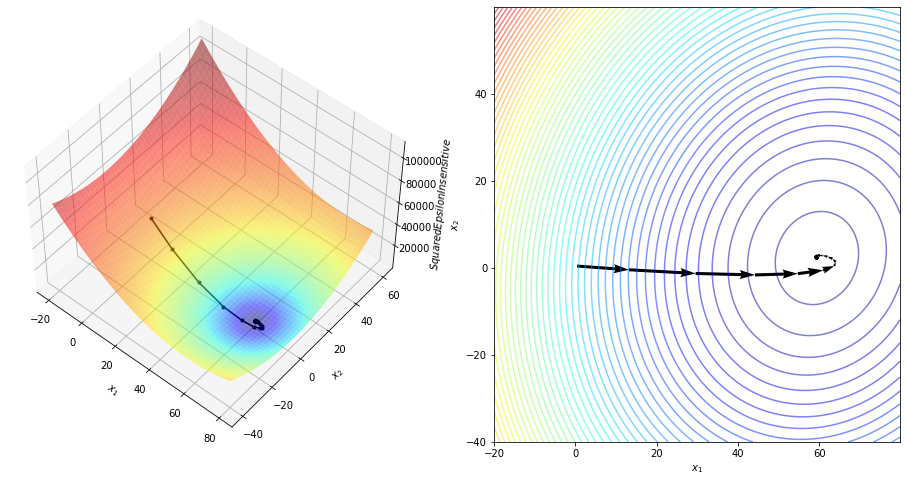

In [39]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [46]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'gd')
custom_primal_svr_squared_eps_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
custom_primal_svr_squared_eps_cv_results

fit_time     train_r2       val_r2  n_iter  \
solver C   momentum epsilon                                               
gd     1   nesterov 0.1      0.258087     0.978130     0.973982     183   
                    0.2      0.175323     0.978129     0.973978     181   
                    0.3      0.181325     0.978129     0.973978     179   
           none     0.1      0.429835     0.978126     0.973975     352   
                    0.2      0.279171     0.978125     0.973974     349   
                    0.3      0.326429     0.978125     0.973972     346   
           standard 0.1      0.312475     0.978130     0.973982     180   
                    0.2      0.127938     0.978130     0.973979     178   
                    0.3      0.184472     0.978129     0.973977     175   
       10  nesterov 0.1      0.019044     0.978184     0.973958      26   
                    0.2      0.016165     0.978184     0.973958      25   
                    0.3      0.015675     0.978184     0.973958      25   
           none     0.1      0.033184     0.978184     0.973958      48   
                    0.2      0.032136     0.978184     0.973957      46   
                    0.3      0.026559     0.978183     0.973955      45   
           standard 0.1      0.017513     0.977871     0.975106      25   
                    0.2      0.016943     0.977874     0.975095      25   
                    0.3      0.017088     0.977872     0.975098      25   
       100 nesterov 0.1      0.004475 -1629.737655 -1601.158587       6   
                    0.2      0.005785 -1637.506672 -1609.161144       6   
                    0.3      0.004273 -1638.224513 -1609.008403       6   
           none     0.1      0.004214   -18.594624   -18.441771       6   
                    0.2      0.004430   -18.653692   -18.498210       6   
                    0.3      0.004730   -18.969060   -18.800697       6   
           standard 0.1      0.021219     0.978184     0.973963      29   
                    0.2      0.019697     0.978184     0.973963      29   
                    0.3      0.018692     0.978184     0.973968      29   

                             train_n_sv  val_n_sv  
solver C   momentum epsilon                        
gd     1   nesterov 0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
           none     0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
           standard 0.1              66        32  
                    0.2              66        32  
                    0.3              66        32  
       10  nesterov 0.1              66        33  
                    0.2              66        33  
                    0.3              66        33  
           none     0.1              66        33  
                    0.2              66        33  
                    0.3              66        32  
           standard 0.1              65        33  
                    0.2              65        33  
                    0.3              65        33  
       100 nesterov 0.1              67        33  
                    0.2              67        33  
                    0.3              67        33  
           none     0.1              67        33  
                    0.2              67        33  
                    0.3              67        33  
           standard 0.1              66        33  
                    0.2              66        33  
                    0.3              66        33

In [47]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [49]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time  train_r2    val_r2  n_iter  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.002499  0.978134  0.974000      90   
                       0.2      0.002433  0.978132  0.974007      89   
                       0.3      0.002493  0.978130  0.974013      87   
          10  -        0.1      0.009630  0.978183  0.973959     784   
                       0.2      0.009278  0.978183  0.973968     780   
                       0.3      0.008759  0.978183  0.973983     759   
          100 -        0.1      0.011892  0.977919  0.972826    1001   
                       0.2      0.012556  0.978147  0.973841    1001   
                       0.3      0.011528  0.978086  0.975133    1001   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              67        32  
                       0.2              66        32  
                       0.3              66        32  
          10  -        0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
          100 -        0.1              67        33  
                       0.2              66        32  
                       0.3              66        32

In [50]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='h!')
primal_svr_squared_eps_cv_results

fit_time     train_r2       val_r2  n_iter  \
solver    C   momentum epsilon                                               
gd        1   nesterov 0.1      0.258087     0.978130     0.973982     183   
                       0.2      0.175323     0.978129     0.973978     181   
                       0.3      0.181325     0.978129     0.973978     179   
              none     0.1      0.429835     0.978126     0.973975     352   
                       0.2      0.279171     0.978125     0.973974     349   
                       0.3      0.326429     0.978125     0.973972     346   
              standard 0.1      0.312475     0.978130     0.973982     180   
                       0.2      0.127938     0.978130     0.973979     178   
                       0.3      0.184472     0.978129     0.973977     175   
          10  nesterov 0.1      0.019044     0.978184     0.973958      26   
                       0.2      0.016165     0.978184     0.973958      25   
                       0.3      0.015675     0.978184     0.973958      25   
              none     0.1      0.033184     0.978184     0.973958      48   
                       0.2      0.032136     0.978184     0.973957      46   
                       0.3      0.026559     0.978183     0.973955      45   
              standard 0.1      0.017513     0.977871     0.975106      25   
                       0.2      0.016943     0.977874     0.975095      25   
                       0.3      0.017088     0.977872     0.975098      25   
          100 nesterov 0.1      0.004475 -1629.737655 -1601.158587       6   
                       0.2      0.005785 -1637.506672 -1609.161144       6   
                       0.3      0.004273 -1638.224513 -1609.008403       6   
              none     0.1      0.004214   -18.594624   -18.441771       6   
                       0.2      0.004430   -18.653692   -18.498210       6   
                       0.3      0.004730   -18.969060   -18.800697       6   
              standard 0.1      0.021219     0.978184     0.973963      29   
                       0.2      0.019697     0.978184     0.973963      29   
                       0.3      0.018692     0.978184     0.973968      29   
liblinear 1   -        0.1      0.002499     0.978134     0.974000      90   
                       0.2      0.002433     0.978132     0.974007      89   
                       0.3      0.002493     0.978130     0.974013      87   
          10  -        0.1      0.009630     0.978183     0.973959     784   
                       0.2      0.009278     0.978183     0.973968     780   
                       0.3      0.008759     0.978183     0.973983     759   
          100 -        0.1      0.011892     0.977919     0.972826    1001   
                       0.2      0.012556     0.978147     0.973841    1001   
                       0.3      0.011528     0.978086     0.975133    1001   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
gd        1   nesterov 0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
              none     0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
              standard 0.1              66        32  
                       0.2              66        32  
                       0.3              66        32  
          10  nesterov 0.1              66        33  
                       0.2              66        33  
                       0.3              66        33  
              none     0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
              standard 0.1              65        33  
                       0.2              65        33  
                      